# scplotter to work with CODEX data prepared by Giotto

See: <https://drieslab.github.io/Giotto_website/articles/codex_mouse_spleen.html>

Go back to scplotter documentation: <https://pwwang.github.io/scplotter/>

In [ ]:
# GiottoData::getSpatialDataset(
#   dataset = "codex_spleen",
#   directory = "data/codex_spleen",
#   verbose = TRUE,
#   dryrun = FALSE
# )

Warning message in GiottoData::getSpatialDataset(dataset = "codex_spleen", directory = "data/codex_spleen", :
“The output directory does not exist and will be created 
”
Warning message in data.table::fread(datasets_file, sep = "\t"):
“Discarded single-line footer: <<sg_mini_kidney	https://github.com/drieslab/spatial-datasets/data/2023_spatial_genomics_mouse_kidney/Raw.zip	>>”
Selected dataset links for: codex_spleen




        dataset
         <char>
1: codex_spleen
                                                                                                                       spatial_locs
                                                                                                                             <char>
1: https://raw.githubusercontent.com/drieslab/spatial-datasets/master/data/2018_codex_spleen/cell_locations/codex_BALBc_3_coord.txt
                                                                                                                              expr_matrix
                                                                                                                                   <char>
1: https://raw.githubusercontent.com/drieslab/spatial-datasets/master/data/2018_codex_spleen/count_matrix/codex_BALBc_3_expression.txt.gz
                                                                                                                                              



Download expression matrix:



Download spatial locations:



Download metadata:



NULL

In [3]:
library(Giotto)

# Ensure Giotto can access a python env
genv_exists <- suppressMessages(checkGiottoEnvironment())
print(genv_exists)

python_path <- file.path(Sys.getenv("HOME"), "miniconda3", "envs", "giotto_env", "bin", "python")
Sys.setenv(RETICULATE_PYTHON = python_path)

invisible(capture.output(suppressMessages(set_giotto_python_path(python_path = python_path))))

# library(scplotter)
devtools::load_all()

[1] TRUE


ℹ Loading scplotter


In [11]:
library(Giotto)

## Set instructions
results_folder <- "data/codex_spleen.results"

instructions <- createGiottoInstructions(
    save_dir = results_folder,
    save_plot = FALSE,
    show_plot = TRUE,
    return_plot = TRUE,
    python_path = python_path
)

data_path <- "data/codex_spleen/"

# 2. create giotto object from provided paths ####
expr_path <- paste0(data_path, "codex_BALBc_3_expression.txt.gz")
loc_path <- paste0(data_path, "codex_BALBc_3_coord.txt")
meta_path <- paste0(data_path, "codex_BALBc_3_annotation.txt")

# read in data information

# expression info
codex_expression <- readExprMatrix(expr_path, transpose = FALSE)
# cell coordinate info
codex_locations <- data.table::fread(loc_path)
# metadata
codex_metadata <- data.table::fread(meta_path)

## stitch x.y tile coordinates to global coordinates
xtilespan <- 1344
ytilespan <- 1008

# TODO: expand the documentation and input format of stitchTileCoordinates. Probably not enough information for new users.
stitch_file <- stitchTileCoordinates(location_file = codex_metadata,
                                     Xtilespan = xtilespan,
                                     Ytilespan = ytilespan)
codex_locations <- stitch_file[,.(Xcoord, Ycoord)]

# create Giotto object
codex_test <- createGiottoObject(expression = codex_expression,
                                 spatial_locs = codex_locations,
                                 instructions = instructions)

codex_metadata$cell_ID <- as.character(codex_metadata$cellID)
codex_test <- addCellMetadata(codex_test, new_metadata = codex_metadata,
                              by_column = TRUE,
                              column_cell_ID = "cell_ID")

# subset Giotto object
cell_metadata <- pDataDT(codex_test)
cell_IDs_to_keep <- cell_metadata[Imaging_phenotype_cell_type != "dirt" & Imaging_phenotype_cell_type != "noid" & Imaging_phenotype_cell_type != "capsule",]$cell_ID

codex_test <- subsetGiotto(codex_test,
                           cell_ids = cell_IDs_to_keep)

## filter
codex_test <- filterGiotto(gobject = codex_test,
                           expression_threshold = 1,
                           feat_det_in_min_cells = 10,
                           min_det_feats_per_cell = 2,
                           expression_values = "raw",
                           verbose = TRUE)

codex_test <- normalizeGiotto(gobject = codex_test,
                              scalefactor = 6000,
                              verbose = TRUE,
                              log_norm = FALSE,
                              library_size_norm = FALSE,
                              scale_feats = FALSE,
                              scale_cells = TRUE)

## add gene & cell statistics
codex_test <- addStatistics(gobject = codex_test,
                            expression_values = "normalized")

## adjust expression matrix for technical or known variables
codex_test <- adjustGiottoMatrix(gobject = codex_test,
                                 expression_values = "normalized",
                                 batch_columns = "sample_Xtile_Ytile",
                                 covariate_columns = NULL,
                                 return_gobject = TRUE,
                                 update_slot = "custom")

python already initialized in this session
 active environment : 'giotto_env'
 python version : 3.10



completed 1: preparation

completed 2: subset expression data

completed 3: subset spatial locations

completed 4: subset cell metadata

completed 5: subset feature metadata

completed 6: subset spatial network(s)

completed 7: subsetted dimension reductions

completed 8: subsetted nearest network(s)

completed 9: subsetted spatial enrichment results




Feature type:  rna 
Number of cells removed:  2  out of  80019 
Number of feats removed:  0  out of  30 


Setting expression [cell][rna] normalized

Setting expression [cell][rna] scaled

calculating statistics for "normalized" expression

Warning message:
“The `update_slot` argument of `adjustGiottoMatrix()` is deprecated as of <NA>
4.1.7.
ℹ Please use the `name` argument instead.
ℹ The deprecated feature was likely used in the base package.
  Please report the issue to the authors.”
Setting expression [cell][rna] custom



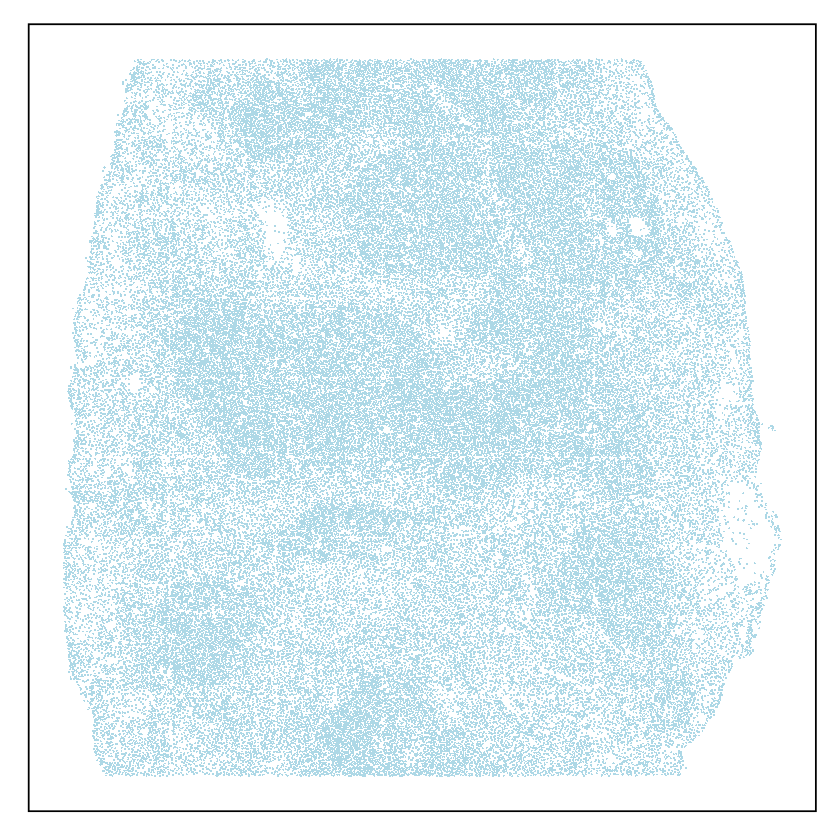

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)

SpatDimPlot(codex_test, color_by = "lightblue", size = 0.25)

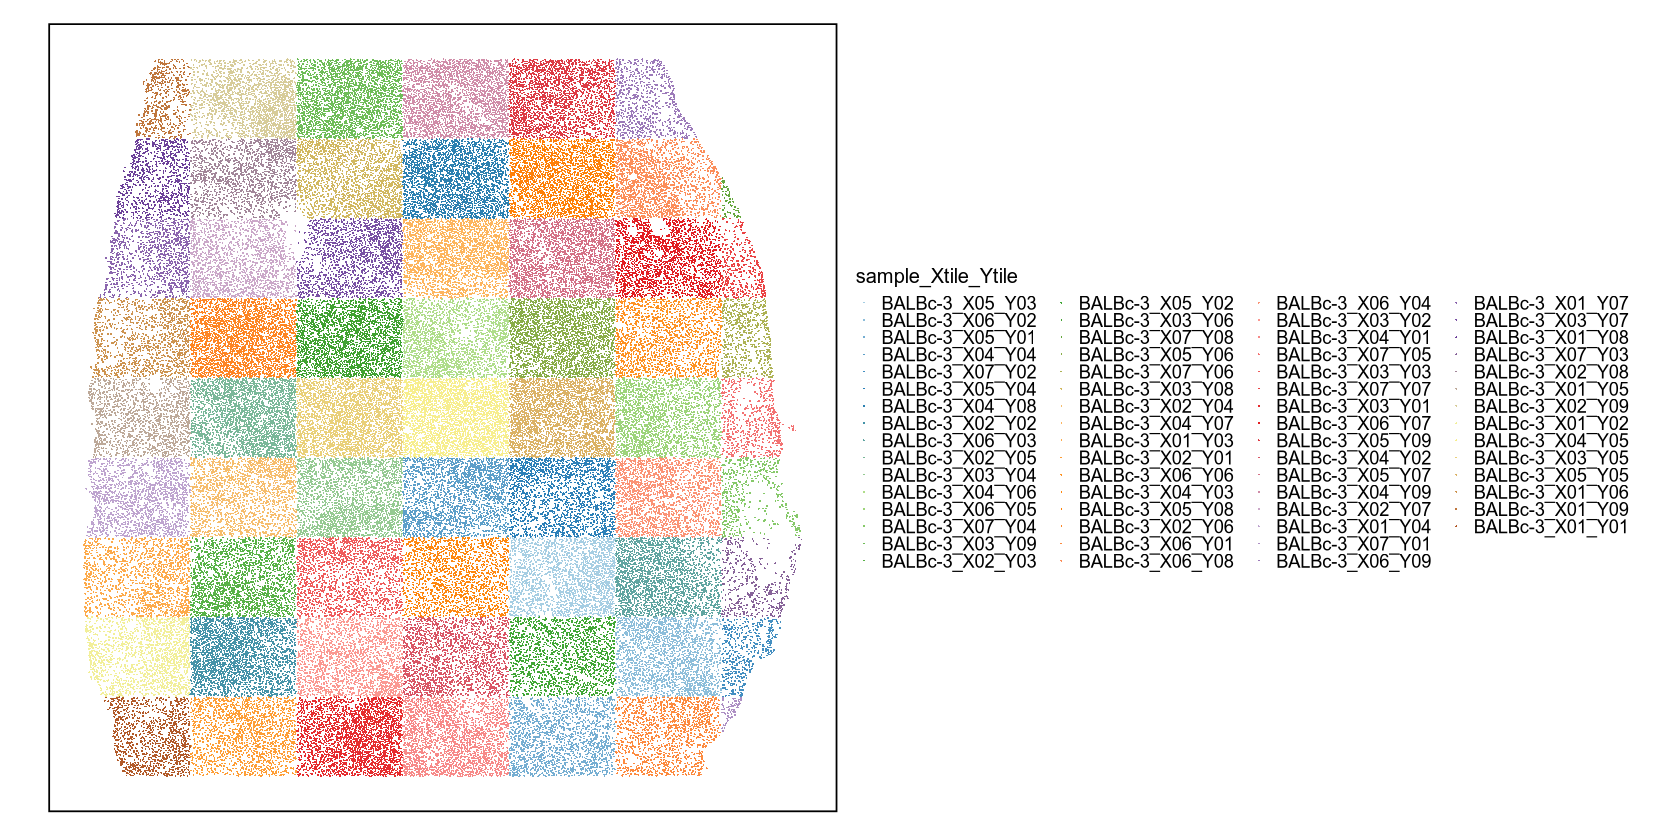

In [19]:
options(repr.plot.width = 14, repr.plot.height = 7)

SpatDimPlot(
    codex_test,
    group_by = "sample_Xtile_Ytile",
    size = 0.2
)

In [20]:
# PCA
codex_test <- runPCA(gobject = codex_test,
                     expression_values = "normalized",
                     scale_unit = TRUE,
                     method = "factominer")
# UMAP
codex_test <- runUMAP(codex_test,
                      dimensions_to_use = 1:14,
                      n_components = 2,
                      n_threads = 12)
## sNN network (default)
codex_test <- createNearestNetwork(gobject = codex_test,
                                   dimensions_to_use = 1:14,
                                   k = 20)

## 0.1 resolution
codex_test <- doLeidenCluster(gobject = codex_test,
                              resolution = 0.5,
                              n_iterations = 100,
                              name = "leiden")

clusters_cell_types <- c("naive B cells", "B cells", "B cells", "naive B cells",
                         "B cells", "macrophages", "erythroblasts",
                         "erythroblasts", "erythroblasts", "CD8 + T cells",
                         "Naive T cells", "CD4+ T cells", "Naive T cells",
                         "CD4+ T cells", "Dendritic cells", "NK cells",
                         "Dendritic cells", "Plasma cells", "endothelial cells",
                         "monocytes")

names(clusters_cell_types) <- c(2, 15, 13, 5, 8, 9, 19, 1, 10, 3, 12, 14, 4, 6,
                                7, 16, 17, 18, 11, 20)

codex_test <- annotateGiotto(gobject = codex_test,
                             annotation_vector = clusters_cell_types,
                             cluster_column = "leiden",
                             name = "cell_types")

cell_metadatadata <- pDataDT(codex_test)
subset_cell_ids <- cell_metadatadata[sample_Xtile_Ytile=="BALBc-3_X04_Y08"]$cell_ID

codex_test_zone1 <- subsetGiotto(codex_test,
                                 cell_ids = subset_cell_ids)

"hvf" was not found in the gene metadata information.
 all genes will be used.

Warning message in .run_pca_factominer(x = t_flex(expr_values), scale = scale_unit, :
“ncp > ncol(x), will be set to ncol(x)”
Setting dimension reduction [cell][rna] pca

Setting dimension reduction [cell][rna] umap



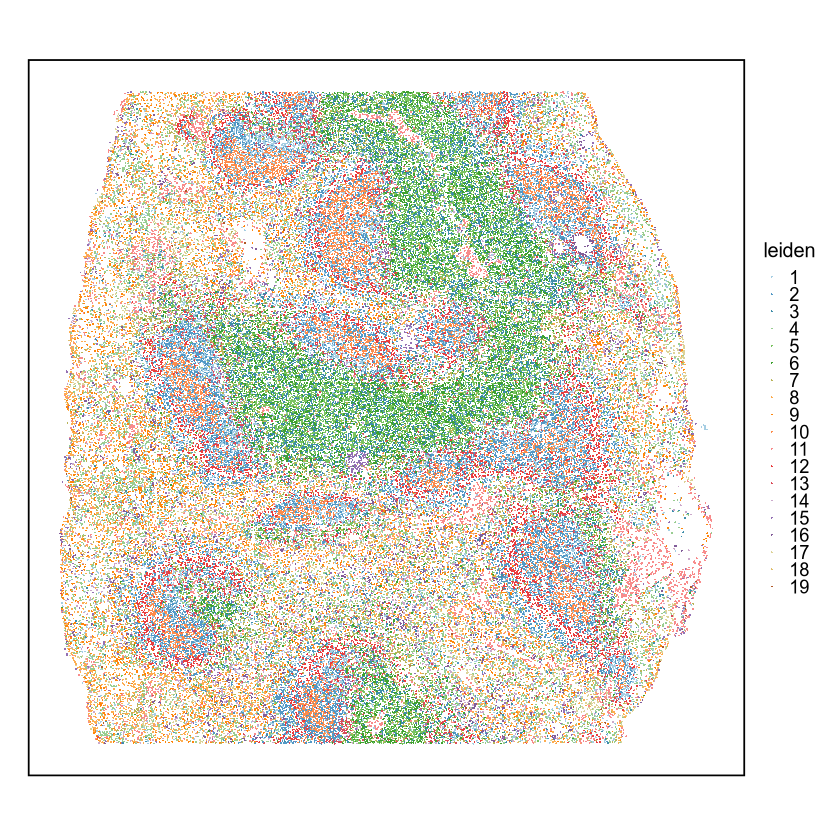

In [32]:
options(repr.plot.width = 7, repr.plot.height = 7)

codex_test@cell_metadata$cell$rna$leiden <- factor(
    as.character(codex_test@cell_metadata$cell$rna$leiden),
    levels = unique(as.character(sort(codex_test@cell_metadata$cell$rna$leiden))))

SpatDimPlot(
    codex_test,
    group_by = "leiden",
    size = 0.2
)

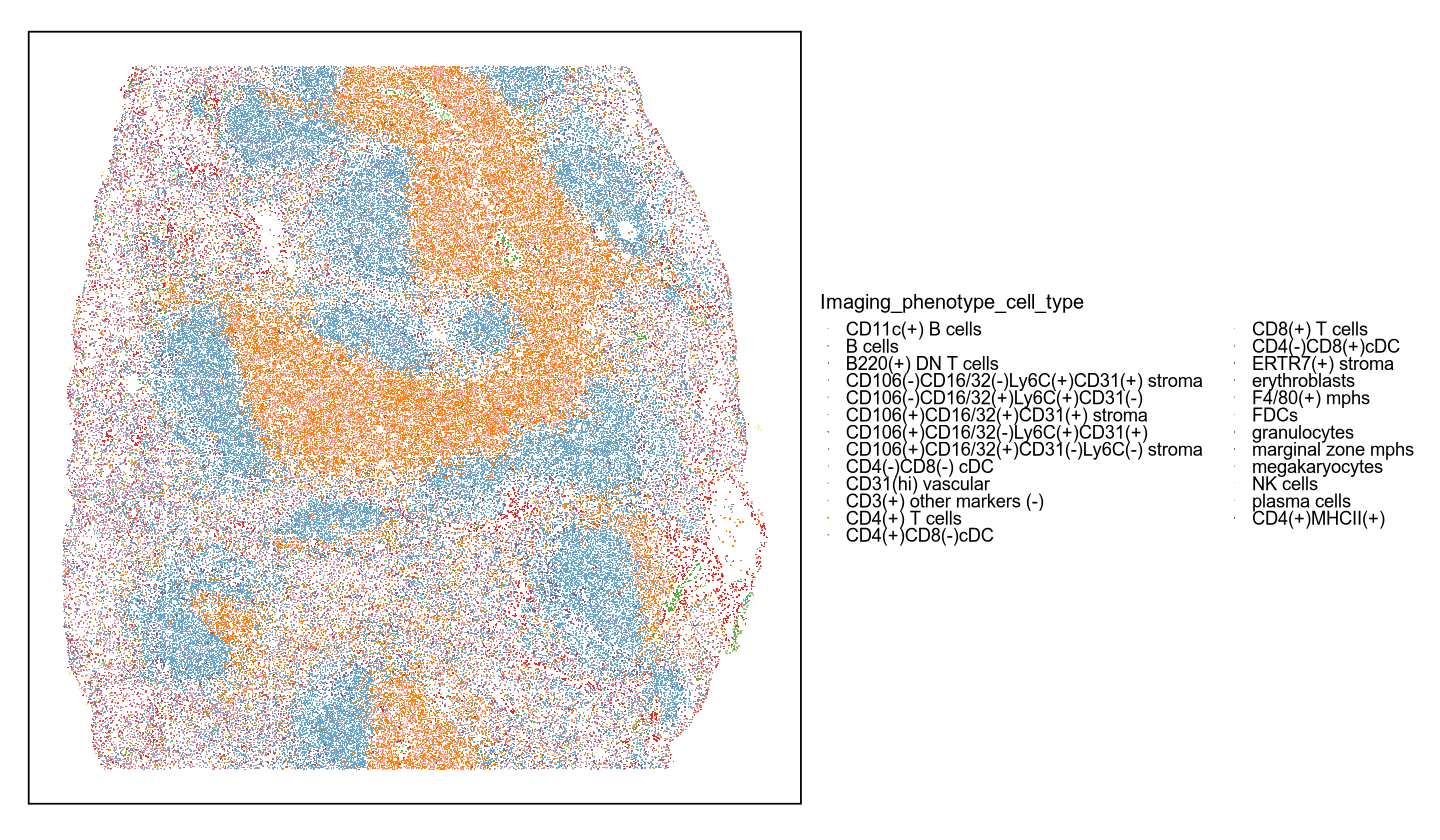

In [34]:
options(repr.plot.width = 12, repr.plot.height = 7)

SpatDimPlot(
    codex_test,
    group_by = "Imaging_phenotype_cell_type",
    size = 0.2
)

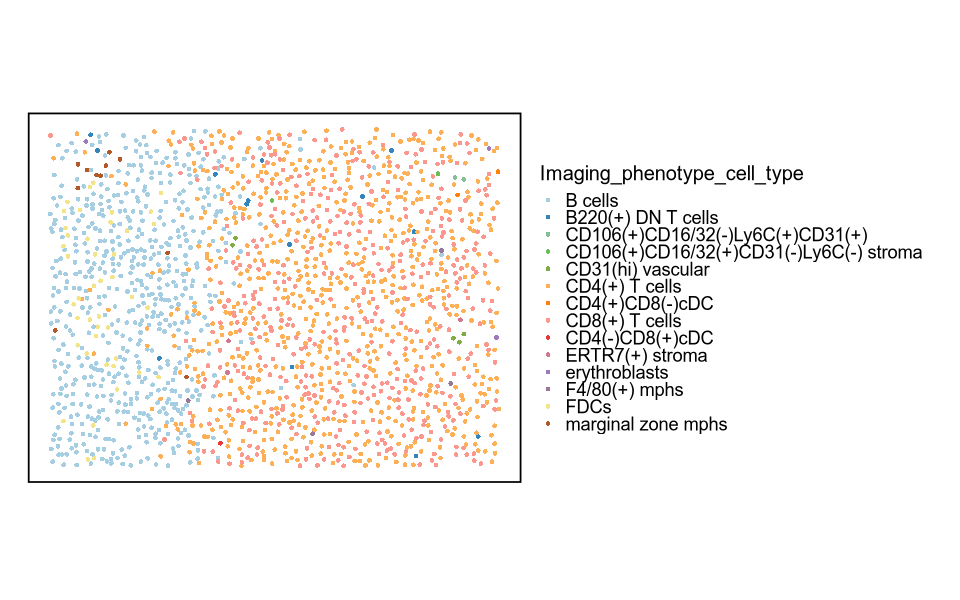

In [36]:
options(repr.plot.width = 8, repr.plot.height = 5)

SpatDimPlot(
    codex_test_zone1,
    group_by = "Imaging_phenotype_cell_type",
    size = 1
)

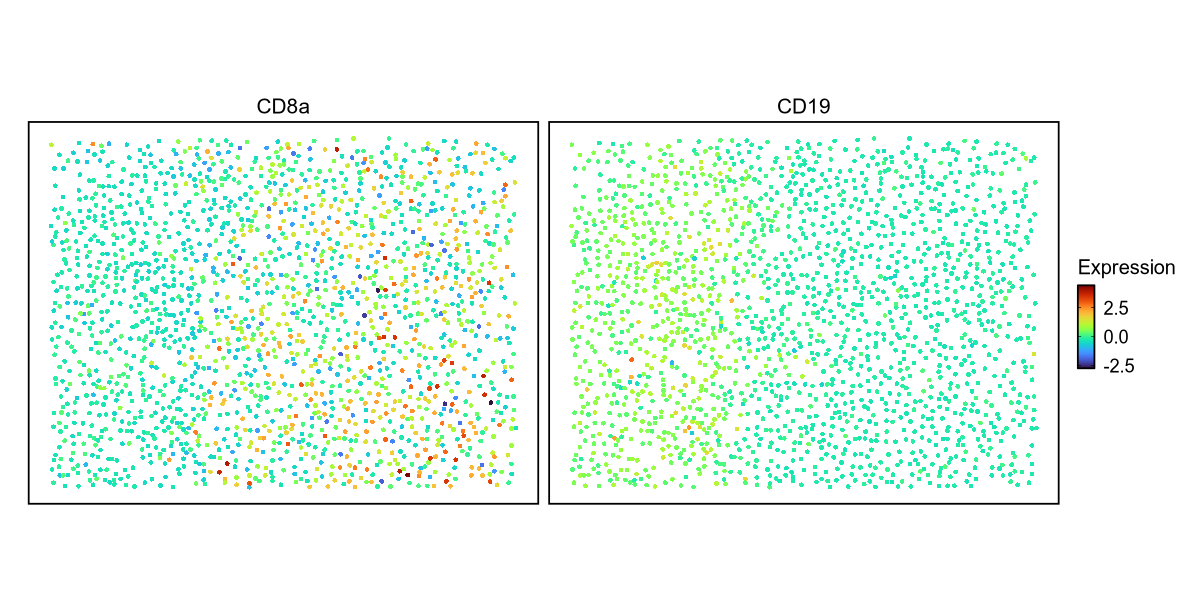

In [39]:
options(repr.plot.width = 10, repr.plot.height = 5)

SpatFeaturePlot(
    codex_test_zone1,
    features = c("CD8a","CD19"),
    layer = "scaled",
    size = 1
)

In [4]:
x <- sessionInfo()
x <- capture.output(print(x))
# hide the BLAS/LAPACK paths
x <- x[!startsWith(x, "BLAS/LAPACK:")]
cat(paste(x, collapse = "\n"))

R version 4.4.3 (2025-02-28)
Platform: x86_64-conda-linux-gnu
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=C              
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Chicago
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scplotter_0.4.0   Giotto_4.2.1      GiottoClass_0.4.7

loaded via a namespace (and not attached):
  [1] fs_1.6.6                    matrixStats_1.5.0          
  [3] spatstat.sparse_3.1-0       bitops_1.0-9               
  [5] devtools_2.4.5              httr_1.4.7                 
  [7] RColorBrewer_1.1-3 